# <u>**Clustering Part 2**</u>

This noteboook follows on from classification part 1.

We will use the `iris` flower dataset once again.

We will explore the solutions built by K-means, DBSCAN and agglomerative hierarchical clustering.



# <u>**The Dataset**</u>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# import the iris dataset
iris = datasets.load_iris()
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

According to the desription, the dataset consists of samples described by four predictor attributes (`sepal length`, `sepal width`, `petal length`, `petal width`, in centimeters) plus a label which can take on three discrete values (`Iris-Setosa`, `Iris-Versicolour` and `Iris-Virginica`). In this notebook, we won't be using the label provided by the dataset

The following code plots the samples in the 2D space where the horizontal axis corresponds to the `sepal length` and the vertical axis to the `sepal width`. 

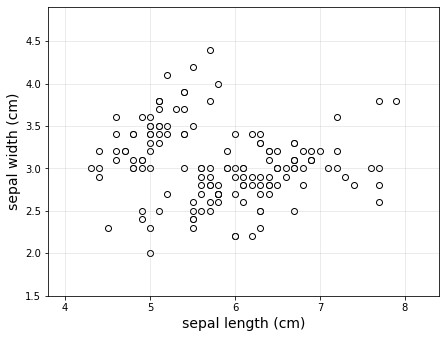

In [ ]:
X = iris.data[:, :2] 
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.set_aspect('equal')

ax.scatter(X[:, 0], X[:, 1], edgecolor='black', c = 'w')

ax.set_xlabel(iris.feature_names[0], fontsize=14)
ax.set_ylabel(iris.feature_names[1], fontsize=14)
ax.grid(alpha=0.3)
ax.set_xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
ax.set_ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
plt.show()

We can also use the first three attributes, `sepal length`, `sepal width` and `petal length`, to define a 3D space and plot the samples in this space. The following code does this.

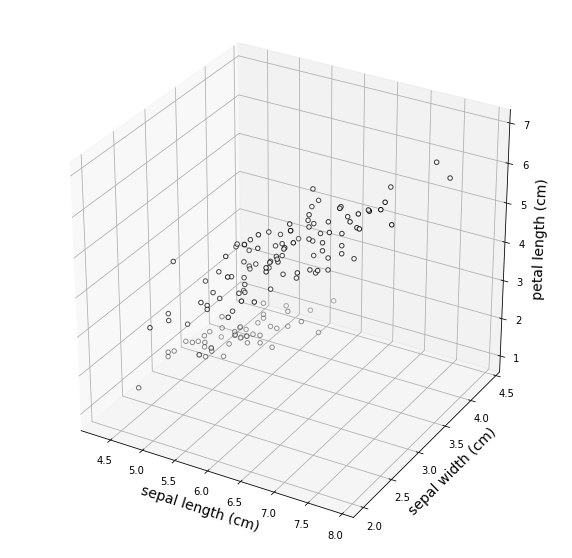

In [ ]:
X = iris.data[:, :3] 
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], edgecolor='black', c = 'w')

ax.set_xlabel(iris.feature_names[0], fontsize=14)
ax.set_ylabel(iris.feature_names[1], fontsize=14)
ax.set_zlabel(iris.feature_names[2], fontsize=14)

plt.show()

#<u>**Choosing the value of K in the K-means algorithm**</u>

Before applying the K-means algorithm we need to decide how many clusters we want to create. In the following cell, we will train the K-means algorithm with half of the iris dataset (training set) and then will obtain the overall distance between samples in the other half of the iris dataset (validation set) and the final centroid. This procedure will be carried out for several values of K, from 1 to 15.

In [ ]:
from scipy.spatial import distance

X = iris.data
Xtr = X[::2,:]  #training set
Xval = X[1::2,:] #validation set

number_of_clusters = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
tol = 0.000001
max_iteration = 100
overalDistToClustersFinal = [np.inf]
TrainCost = []
ValCost = []
np.random.seed(seed = 3)


for k in number_of_clusters: 
    
    difference = np.inf
    iteration = 0
    centers = np.random.normal(size=[k, 4]) + np.ones((k,1)) * np.mean(Xtr, axis=0)
    overalDistToClustersIter = [np.inf]


    while difference>tol and iteration<max_iteration:    
        overalDistToClusters3_new = 0.0
        distanceMatrix3 = distance.cdist(Xtr, centers, 'euclidean')
        whichCenterNearest = np.argsort(distanceMatrix3, axis=1)[:, 0]

        for index in range(len(Xtr)):
            overalDistToClusters3_new += distanceMatrix3[index][whichCenterNearest[index]]
      
        difference = overalDistToClustersIter[-1] - overalDistToClusters3_new
        overalDistToClustersIter.append(overalDistToClusters3_new)
    
        for i in range(k):
            indx = whichCenterNearest==i
            if indx.any():
                centers[i,:] = np.mean(Xtr[indx,:], axis = 0)
        iteration +=1
    

    TrainCost.append(overalDistToClustersIter[-1])
    
    overalDistToClustersVal = 0.0
    distanceMatrix3 = distance.cdist(Xval, centers, 'euclidean')
    whichCenterNearest = np.argsort(distanceMatrix3, axis=1)[:, 0]
    for index in range(len(Xtr)):
        overalDistToClustersVal += distanceMatrix3[index][whichCenterNearest[index]]

    ValCost.append(overalDistToClustersVal)

Let's now plot the overall distance between samples in each cluster and their centroid as a function of K for the train and validation sets.

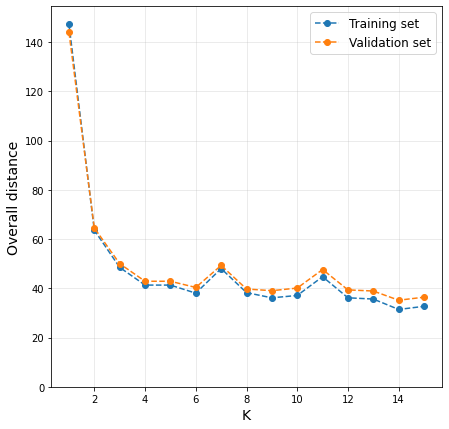

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

ax.set_xlabel("K", fontsize=14)
ax.set_ylabel("Overall distance", fontsize=14)
ax.grid(alpha=0.3)

ax.plot(number_of_clusters, TrainCost, '--', marker = 'o', label='Training set')
ax.plot(number_of_clusters, ValCost, '--', marker = 'o', label='Validation set')
ax.set_ylim([0, TrainCost[0]*1.05])

ax.legend(fontsize=12)

plt.show()

# <u>**DBSCAN**</u>

The DBSCAN algorithm builds clusters based on the notion of connectivity. We will first visualise a clustering solution on the 2D space formed by the `sepal length` and the `sepal width` attributes. In addition to 2 clusters (red and blue samples), DBSCAN returns outlier samples that are not assigned to any cluster.

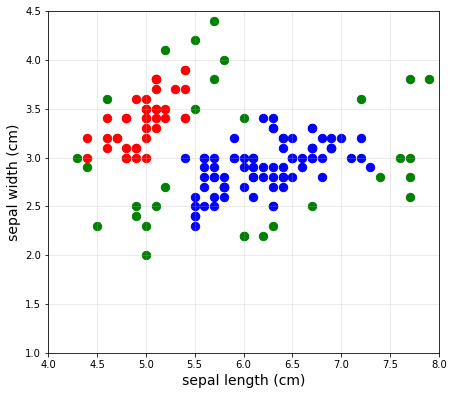

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=0.25, min_samples=8).fit(X[:,:2])
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

colors = ("red", "blue", "green")
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.set_xlabel(iris.feature_names[0], fontsize=14)
ax.set_ylabel(iris.feature_names[1], fontsize=14)
ax.grid(alpha=0.3)
ax.set_xlim(4, 8)
ax.set_ylim(1, 4.5)

for l in [-1, 0, 1]:
  ax.scatter(X[labels == l, 0], X[labels == l, 1],
             s=70, c=colors[l])

DBSCAN proceeds by obtaining the density of samples around each sample. The density is estimated by counting the number of samples within a given radius. If this number is greater than a pre-specified threshold, DBSCAN treats the sample as a core sample, otherwise it will be a border sample. 

Different thresholds produce different solutions. In the code below, we obtain and plot the number of clusters and outliers identified by DBSCAN for different threshold values. Note that the 4 attributes of the dataset are used by DBSCAN.

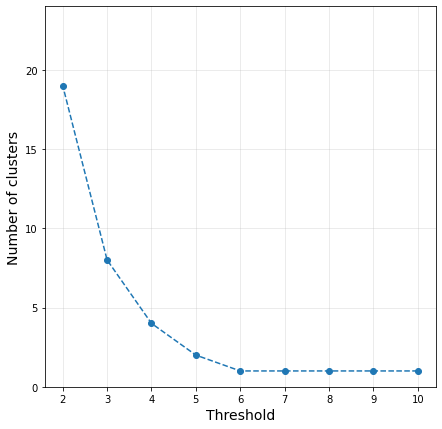

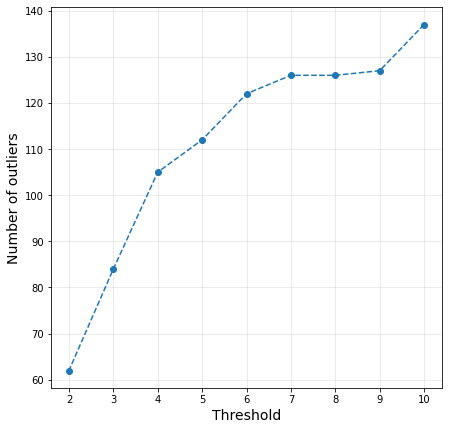

In [ ]:
number_of_samples_threshold = np.array([10, 9, 8, 7, 6, 5, 4, 3, 2])
number_of_clusters = []
number_of_outliers = []

for s in number_of_samples_threshold: 
    db = DBSCAN(eps=0.25, min_samples=s).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_outliers_ = list(labels).count(-1)

    number_of_clusters.append(n_clusters_)
    number_of_outliers.append(n_outliers_)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

ax.set_xlabel("Threshold", fontsize=14)
ax.set_ylabel("Number of clusters", fontsize=14)
ax.grid(alpha=0.3)
ax.set_ylim(0,24)
ax.plot(number_of_samples_threshold, number_of_clusters, '--', marker = 'o')


fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)

ax.set_xlabel("Threshold", fontsize=14)
ax.set_ylabel("Number of outliers", fontsize=14)
ax.grid(alpha=0.3)
ax.plot(number_of_samples_threshold, number_of_outliers, '--', marker = 'o')

Note how the number of clusters decrease as we increase the threshold.

# <u>**Hierarchical Clustering**</u>

Hierarchical clustering builds clustering arrangements at different levels. The code below imports and defines functions that we will use to apply an agglomerative clustering algorithm and visualize its solution

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Now we can apply an agglomerative clustering algorithm on the iris dataset

In [ ]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
IrisAggmodel = model.fit(X)

And finally obtain the resulting dendrogram

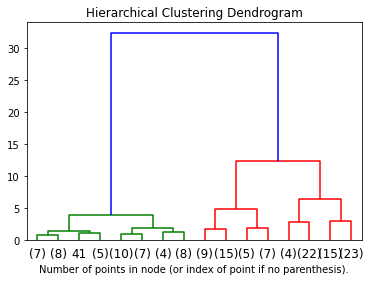

In [ ]:
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(IrisAggmodel, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Branching in the dendrogram represents one of the clusters at one level being split

Note that the dendrogram includes the number of samples in each cluster at the lowest level between parenthesis or the sample index if the cluster consists of just one sample. Check that the number of samples in each cluster add up to 150.